In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from community import community_louvain
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import plotly.graph_objects as go

In [2]:
def calculate_modularity(small_cluster, cluster, G):
    for k in range(len(small_cluster)):
        item = small_cluster[k]
        key = list(item.keys())
        item[key[0]] = cluster
        small_cluster[k] = item
    merged_partition = small_cluster + partition_dict[cluster]
    new_partition_list = []
    for j in range(len(partition_dict)):
        if j != i:
            if j == cluster:
                for item in merged_partition:
                    new_partition_list.append(item)
            else:
                for item in partition_dict[j]:
                    new_partition_list.append(item)
    new_partition_dict = {}
    for item in new_partition_list:
        new_partition_dict.update(item)
    modularity_cluster = community_louvain.modularity(new_partition_dict, G)
    return modularity_cluster

def link_prediction(graph, node1, node2):
    common_neighbors = list(nx.common_neighbors(graph, node1, node2))
    similarity = sum(1 / np.log(G.degree(neighbor)) for neighbor in common_neighbors) if common_neighbors else 0
    return similarity

def recommend_links(graph, node, top_k=5):
    similarities = [(other_node, link_prediction(graph, node, other_node)) for other_node in graph.nodes if other_node != node]

    sorted_similarities = sorted(similarities, key=lambda x: x[1], reverse=True)

    return sorted_similarities[:top_k]

def simulate_missing_links(graph, fraction_to_remove=0.1):
    edges_to_remove = np.random.choice(list(graph.edges), size=int(fraction_to_remove * len(graph.edges)), replace=False)
    graph_removed_links = graph.copy()
    graph_removed_links.remove_edges_from(edges_to_remove)
    return edges_to_remove, graph_removed_links

def calculate_modularity_profile(G, partition_dict):
    resolutions = np.arange(0.1, 2.1, 0.1)
    modularity_profile = []

    for resolution in resolutions:
        partition = community_louvain.best_partition(G, resolution=resolution)
        modularity = community_louvain.modularity(partition, G)
        modularity_profile.append(modularity)

    return resolutions, modularity_profile

Tamanho da comunidade 01: 14, Tamanho da comunidade 02:48



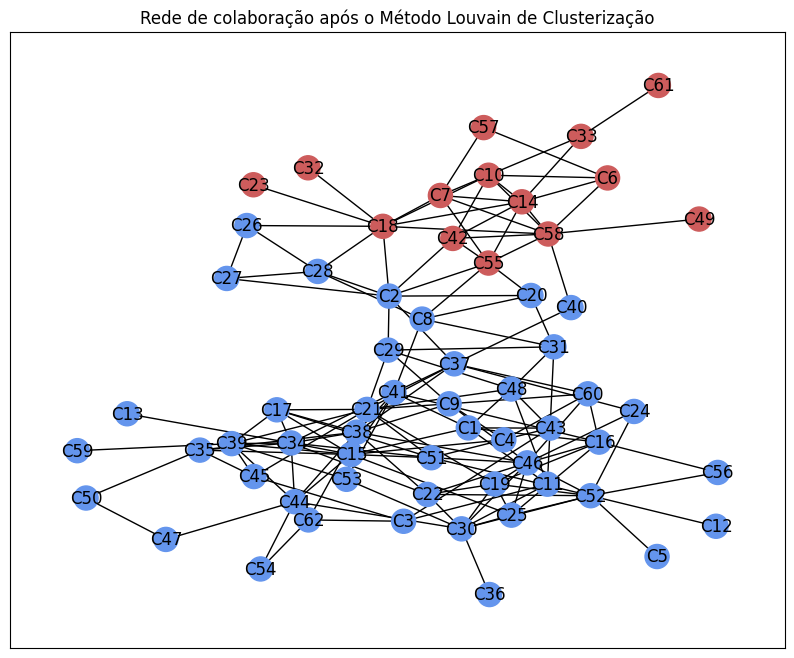

In [3]:
if __name__ == '__main__':
    # Leitura do arquivo gml
    inputfilePath = "collaborator.gml"
    G = nx.Graph()
    # Computando o grafo
    G = nx.read_gml(inputfilePath)
    nodelist = list(G.nodes)
    # Entrando melhor partição
    partition = community_louvain.best_partition(G)

    # Gerando o dicionário apartir do label da partição
    noofpartitions = int(len(set(partition.values())))
    partition_dict = {}
    for node, label in partition.items():
        if label not in partition_dict.keys():
            partition_dict[label] = [{node: label}]
        else:
            partition_dict[label].append({node: label})

    # Computando o tamanho das partições
    partition_sizes = []
    for i in range(len(partition_dict)):
        partition_sizes.append(len(partition_dict[i]))
    # Encontrando as duas maiores partições
    partition_indices = np.argsort(partition_sizes)
    top_two_cluster_indices = partition_indices[-2:]

    # Algoritmo guloso to merge partição
    for i in range(len(partition_dict)):
        if i not in top_two_cluster_indices:
            cluster1 = top_two_cluster_indices[0]
            cluster2 = top_two_cluster_indices[1]
            small_cluster1 = partition_dict[i]
            modularity_cluster1 = calculate_modularity(small_cluster1, cluster1, G)
            small_cluster2 = partition_dict[i]
            modularity_cluster2 = calculate_modularity(small_cluster2, cluster2, G)
            if modularity_cluster1 > modularity_cluster2:
                partition_dict[i] = small_cluster1
            else:
                partition_dict[i] = small_cluster2

    # Organize nodelist community as per the final partition list.
    node_community_list = {}
    for i in range(len(partition_dict)):
        for item in partition_dict[i]:
            node_community_list.update(item)
    nodelist_comm = {}
    for node in nodelist:
        for keynode, community in node_community_list.items():
            if node == keynode:
                nodelist_comm[node] = community
    community_list = []
    for node, community in nodelist_comm.items():
        community_list.append(community)

    set_community = set(community_list)
    node_color_list = []
    count = 0
    for comm in community_list:
        if comm == list(set_community)[0]:
            count += 1
            node_color_list.append('indianred')
        if comm == list(set_community)[1]:
            node_color_list.append('cornflowerblue')

    print("Tamanho da comunidade 01: " + str(count) + ", Tamanho da comunidade 02:" + str(62 - count) + '\n')

    pos = nx.kamada_kawai_layout(G)
    plt.figure(figsize=(10, 8))
    nx.draw_networkx(G, pos=pos, node_color=node_color_list, with_labels=True)
    plt.title('Rede de colaboração após o Método Louvain de Clusterização')
    plt.show()
    plt.close()

In [4]:
    pos = nx.kamada_kawai_layout(G)
    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')

    node_x = []
    node_y = []
    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        marker=dict(
            showscale=True,
            colorscale='YlGnBu',
            size=10,
            colorbar=dict(
                thickness=15,
                title='Conexões dos nós',
                xanchor='left',
                titleside='right'
            )
        )
    )

    node_adjacencies = []
    node_text = []
    for node, adjacencies in enumerate(G.adjacency()):
        node_adjacencies.append(len(adjacencies[1]))
        node_text.append('# de conexões: ' + str(len(adjacencies[1])))

    node_trace.marker.color = node_adjacencies
    node_trace.text = node_text

    fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=0, l=0, r=0, t=0),
                        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

    fig.show()

In [5]:
# Convertendo a lista de comunidade em labels
labels = np.array(['Comunidade 1' if comm == list(set_community)[0] else 'Comunidade 2' for comm in community_list])

# Features
features = np.array([[G.degree(node)] for node in nodelist])

# Dividindo os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Inicializando o classificador random forest
clf = RandomForestClassifier(class_weight='balanced', n_estimators=100, max_depth=None, random_state=42)
clf.fit(X_train, y_train)

# Predições
y_pred = clf.predict(X_test)

# Gerando classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

Comunidade 1       0.67      0.40      0.50         5
Comunidade 2       0.70      0.88      0.78         8

    accuracy                           0.69        13
   macro avg       0.68      0.64      0.64        13
weighted avg       0.69      0.69      0.67        13



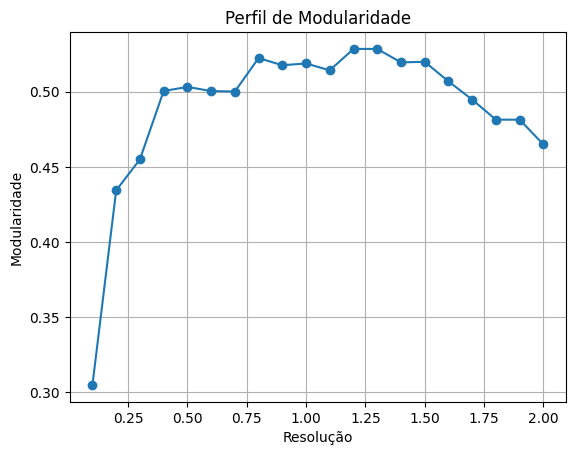

In [6]:
# Calculo do perfil de modularidade
resolutions, modularity_profile = calculate_modularity_profile(G, partition)

# Plot perfil de modularidade
plt.plot(resolutions, modularity_profile, marker='o')
plt.title('Perfil de Modularidade')
plt.xlabel('Resolução')
plt.ylabel('Modularidade')
plt.grid(True)
plt.show()